# March Madness Predictor Kaggle Competition
## Training
This script shows the training of a neural network for prediction of the 2017
#### Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf # r0.12
import os


## Get datasets

In [2]:
RgRes = pd.read_csv('RegularSeasonCompactResults.csv')
PSRes = pd.read_csv('TourneyCompactResults.csv')

with open('id2team.pickle', 'rb') as handle :
    id2team_dict = pickle.load(handle)
with open('team2id.pickle', 'rb') as handle :
    team2id_dict = pickle.load(handle)
with open('stats_dictionary.pickle', 'rb') as handle :
    stats_dict = pickle.load(handle)

In [3]:
RgRes.tail()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
150679,2017,132,1276,71,1458,56,N,0
150680,2017,132,1343,71,1463,59,N,0
150681,2017,132,1348,70,1433,63,N,0
150682,2017,132,1374,71,1153,56,N,0
150683,2017,132,1407,59,1402,53,N,0


In [4]:
PSRes.tail()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
2045,2016,146,1314,88,1323,74,N,0
2046,2016,146,1393,68,1438,62,N,0
2047,2016,152,1314,83,1393,66,N,0
2048,2016,152,1437,95,1328,51,N,0
2049,2016,154,1437,77,1314,74,N,0


In [5]:
"""Remove season where no stats information is available in stats_dict (from 2002)"""
RgRes = RgRes.ix[RgRes['Season'] >= 2002, :    ].reset_index(drop = True)
PSRes = PSRes.ix[ PSRes['Season'] >= 2002, :    ].reset_index(drop = True)

In [6]:
RgRes.shape

(81191, 8)


### Verify teams from training and validation df have entries in the stats dictionary

In [7]:
print(RgRes.shape)

for ix in RgRes.index :
    teamA = RgRes.ix[ix, 'Wteam']
    teamB = RgRes.ix[ix, 'Lteam']
    season = RgRes.ix[ix, 'Season']
    
    if stats_dict.get(season).get(id2team_dict.get(teamA)) is None :
        print("{} ({}) is not in stat_dict for year {}".format(id2team_dict.get(teamA), teamA, season))
        RgRes.drop(ix, axis = 0, inplace = True)
    elif stats_dict.get(season).get(id2team_dict.get(teamB)) is None :
        print("{} ({}) is not in stat_dict for year {}".format(id2team_dict.get(teamB), teamB, season))
        RgRes.drop(ix, axis = 0, inplace = True)
RgRes.reset_index(drop = True)
print(RgRes.shape)

(81191, 8)
Loy Marymount (1258) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (1254) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Loy Marymount (1258) is not in stat_dict for year 2002
Long Island (

In [8]:
print(PSRes.shape)

for ix in PSRes.index :
    teamA = PSRes.ix[ix, 'Wteam']
    teamB = PSRes.ix[ix, 'Lteam']
    season = PSRes.ix[ix, 'Season']
    
    if stats_dict.get(season).get(id2team_dict.get(teamA)) is None :
        print("{} ({}) is not in stat_dict for year {}".format(id2team_dict.get(teamA), teamA, season))
        PSRes.drop(ix, axis = 0, inplace = True)
    elif stats_dict.get(season).get(id2team_dict.get(teamB)) is None :
        print("{} ({}) is not in stat_dict for year {}".format(id2team_dict.get(teamB), teamB, season))
        PSRes.drop(ix, axis = 0, inplace = True)
PSRes.reset_index(drop = True)
print(PSRes.shape)

(978, 8)
Long Island (1254) is not in stat_dict for year 2011
Long Island (1254) is not in stat_dict for year 2012
Long Island (1254) is not in stat_dict for year 2013
(975, 8)


## Helper Functions

In [9]:
import madness as mad
help(mad)
            

Help on module madness:

NAME
    madness

FUNCTIONS
    make_pred_arr(SS)
        Makes an array of matchups that will be fed to the model for prediction.
    
    parse_result(df, game_index)
        Converts a given result into a 1-dimensional array composed of the
        home (A) and away (B) team season statistics, retrieved from the stats dict.
        Function requires the `id2team_dict` and `stats_dict` to be available in the global environment.
    
    prepare_batch(df, epoch_ix_list, batch_size, verbose=False)
        Utilizes parse_result fn to return arrays of data and labels.

DATA
    handle = <_io.BufferedReader name='stats_dictionary.pickle'>
    id2team_dict = {1101: 'Abilene Chr', 1102: 'Air Force', 1103: 'Akron',...
    stats_dict = {2002: {'Air Force': {'AdjustD': 0.26086956521739185, 'Ad...
    team2id_dict = {'Abilene Chr': 1101, 'Air Force': 1102, 'Akron': 1103,...

FILE
    /Users/ccthomps/Documents/Python Files/Kaggle Competitions/March Madness/madness.py




## Generate Validation Set (Tournament Games)

In [10]:
PSRes.shape

(975, 8)

In [11]:
valid_index = PSRes.index.tolist()
valid_X, valid_y, valid_scores = mad.prepare_batch(PSRes, valid_index, len(valid_index))
print(valid_X.shape, valid_y.shape)
print(np.mean(valid_y,axis=0))

(975, 24) (975, 2)
[ 0.48307692  0.51692308]


**NOTE:** If neutral floor, the winning team is automatically assigned as the A team.  This is why all tournament games show up as A winning.  But as these will only be used for validation, no effect on training will occur.  

In [12]:
SS = pd.read_csv('SampleSubmission.csv')

In [13]:
arr4pred = mad.make_pred_arr(SS = SS['Id'])

## Training

In [14]:
% run -i 'NN/PARAMS.py'

In [15]:
version_ID = 'v5.0'
initiate_model = True

In [16]:
% run -i 'NN/GRAPH.py'

In [17]:
% run -i 'NN/SESSION.py'

Weight and bias variables initialized!

Checkpoint saver initialized!

Tensorboard initialized!
To view your tensorboard dashboard summary, run the following on the command line:

tensorboard --logdir='/Users/ccthomps/Documents/Python Files/Kaggle Competitions/March Madness/MODELS/v5.0/Tensorboard_logs'


TRAINING MM Predictor...
Epoch 1 completed : 80128 games observed. Model checkpoint created!
Epoch 2 completed : 160256 games observed. Model checkpoint created!
Epoch 3 completed : 240384 games observed. Model checkpoint created!


## Predictions

In [18]:
% run -i 'NN/PREDICTIONS.py'

Loading version v5.0
Metadata dictionary loaded!
Initializing restorer...
Weights and biases retrieved!  Picking up at 3 epochs completed : 240384 training images observed

Predicting matches from the NCAA 2016-17 Season Tournament...

TRAINING MM Predictor...


In [19]:
np.mean(preds, axis = 0)

array([ 0.50490957,  0.49509087], dtype=float32)

In [28]:
SS['Pred'] = preds
SS_clip = SS.copy()
SS_clip['Pred'] = np.clip(SS_clip['Pred'], a_min=0.04, a_max=0.96)
SS.to_csv(version_ID+'_predictions.csv', index = False)
SS_clip.to_csv(version_ID+'_clip_predictions.csv', index = False)

In [21]:
SS_preview = SS.copy()
for ix, i in enumerate(SS_preview['Id']) :
    SS_preview.ix[ix, 'A'] = id2team_dict.get(int(i.split('_')[1]))
    SS_preview.ix[ix, 'B'] = id2team_dict.get(int(i.split('_')[2]))

In [23]:
SS_preview = SS_preview.sort_values(by = ['A'], axis = 0).reset_index(drop = True)

In [24]:
print(SS_preview)

                  Id      Pred              A                B
0     2017_1112_1116  0.626322        Arizona         Arkansas
1     2017_1112_1321  0.681646        Arizona     Northwestern
2     2017_1112_1323  0.557153        Arizona       Notre Dame
3     2017_1112_1329  0.586323        Arizona      Oklahoma St
4     2017_1112_1332  0.508365        Arizona           Oregon
5     2017_1112_1343  0.819667        Arizona        Princeton
6     2017_1112_1344  0.734802        Arizona       Providence
7     2017_1112_1345  0.551046        Arizona           Purdue
8     2017_1112_1348  0.750054        Arizona     Rhode Island
9     2017_1112_1355  0.964814        Arizona      S Dakota St
10    2017_1112_1371  0.666300        Arizona       Seton Hall
11    2017_1112_1374  0.526450        Arizona              SMU
12    2017_1112_1376  0.685125        Arizona   South Carolina
13    2017_1112_1388  0.598263        Arizona     St Mary's CA
14    2017_1112_1411  0.972029        Arizona      TX S

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

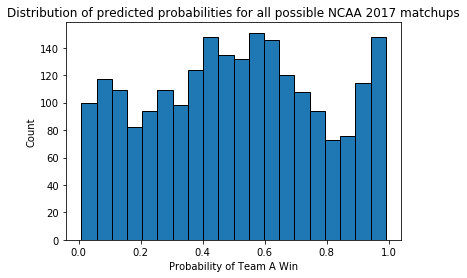

In [35]:
plt.figure()
plt.hist(SS_preview['Pred'], bins = 20, edgecolor='black')
plt.xlabel('Probability of Team A Win')
plt.ylabel('Count')
plt.title('Distribution of predicted probabilities for all possible NCAA 2017 matchups')
plt.show()

In [27]:
SS_preview.to_csv('predictions.csv')